## Set up my coding enviroment importing useful libraries

#### Libraries:

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,Ridge,LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.multioutput import MultiOutputRegressor
import multiprocessing
from sklearn.model_selection import RepeatedKFold

%matplotlib inline 

#### Load the data:

In [232]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
oil=pd.read_csv("oil.csv")
holidays=pd.read_csv("holidays_events.csv")
stores=pd.read_csv("stores.csv")
transactions=pd.read_csv("transactions.csv")

# Get, clean and explore the data:

## Collect and clean the data, concatenate and merge it into a single dataset, and perform basic exploration:

Before concat train and test, create a new column in both datasets, called "is_test", in order to split the data once i finished the feature engineering proces.

In [102]:
train["is_test"]=0
test["is_test"]=1

all_data=pd.DataFrame
all_data=pd.concat([train, test])
all_data.head()

,id,date,store_nbr,family,sales,onpromotion,is_test
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0


In [103]:
all_data.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
is_test            0
dtype: int64

Missing values in "sales" correspond to NaN in test data. So, don't worry.

## 1) oil.csv:

**oil.csv**: daily oil price. Since, Ecuador is an oil-dependent country and it's economical health is highly vulnerable to movements in this commoditie, we consider oil price's a very valuable information to our goal.

Let's explore this dataset

In [233]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


#### Missing values:

In [237]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

#### Imputing missing values

Fill NaN values with **interpolate** method.

In [107]:
oil["dcoilwtico"]=oil["dcoilwtico"].interpolate()

In [108]:
oil=oil.fillna(method="bfill")

In [109]:
oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

In [110]:
oil.shape

(1218, 2)

Now oil dataset is empty for NaN values

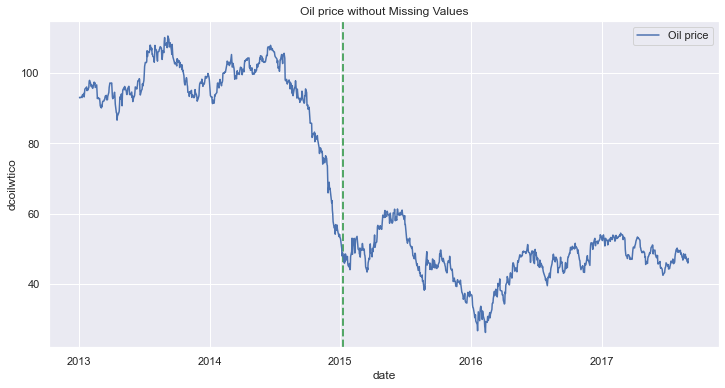

In [265]:
oil_d=oil.copy()
oil_d["date"]=pd.to_datetime(oil_d["date"])
plt.figure(figsize=(12,6))
plt.axvline(x=16445, color='g', linestyle='--', lw=2)
plt.title("Oil price without Missing Values")
sns.lineplot(data=oil_d, x="date", y="dcoilwtico", label="Oil price")
plt.show()

#### Merge:
It's time to **merge** oil dataset to all_data

In [112]:
oil_data=pd.DataFrame
oil_data=all_data.merge(oil, on="date", how="left") #With how="left" we'll keep the values in all_data, no matter if they match with oil values or not

In [113]:
oil_data.dcoilwtico=oil_data.dcoilwtico.fillna(method="bfill")

In [114]:
oil_data.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
is_test            0
dcoilwtico         0
dtype: int64

#### Data exploratory:

At the beginning of this section, we asume that oil price and sales are correlated. Now, we could evaluate this assumption exploring our data.

In the graph above we can see a notable drop in the price of oil (marked with the green dotted line). Next, we will analyze if the sales of the store are correlated with the price of oil, emphasizing this sharp drop in its price at the beginning of 2015.

Let's see how family sales (our target variable) distributed across the different oil prices.

In [115]:
oil_test=oil_data[oil_data.is_test==0]

In [116]:
b=oil_test.groupby(["family","date","dcoilwtico"]).sales.sum().reset_index()

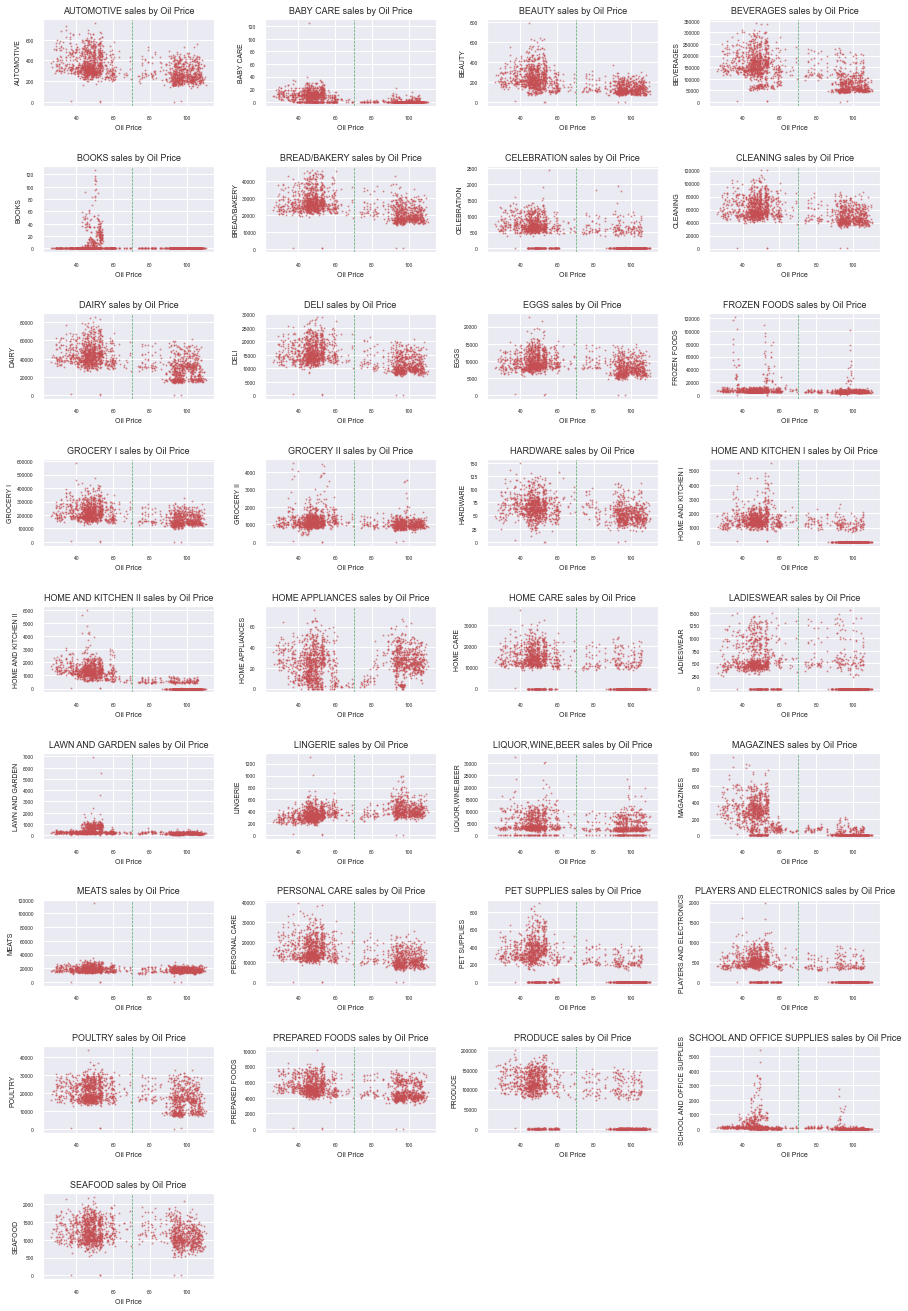

In [117]:
parameters = {'xtick.labelsize': 5, 'ytick.labelsize': 5}
plt.rcParams.update(parameters)

i=1
plt.figure(figsize=(15, 20))

for fam in b.family.unique():
    
    plt.subplot(9,4,i)
    plt.scatter(b.dcoilwtico[b.family==fam],b.sales[b.family==fam], s=0.9, c="r", alpha= 0.5)
    plt.axvline(x=70, color='g', linestyle='--', lw=0.7)
    plt.title(fam+" sales by Oil Price", fontsize=9)
    plt.xlabel("Oil Price", fontsize=7)
    plt.ylabel(fam, fontsize=7)    
    i=i+1
       
plt.subplots_adjust(top = 1, wspace=0.3, hspace=0.7)
plt.show()

As we can see, there is a decrease in sales for each product family when Oil price is upper 70$ (represented by a green line). Sales is highly correlated with Oil price.

## 2) stores.csv:

**stores.csv**: have potentially useful info about stores like: city, state. Stores located in large cities, generally, have a higher sales volume.

In [118]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [119]:
stores["type"].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [120]:
all_data.head()

,id,date,store_nbr,family,sales,onpromotion,is_test
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0


Transform "type" in a numerical variable. To do that, we use **OrdinalEncoder** from **ScikitLearn**

In [121]:
encoder = OrdinalEncoder(categories=[["A", "B", "C", "D", "E"]])

encoder.fit(stores[["type"]])
stores["type_num"] = encoder.transform(stores[["type"]])

In [122]:
stores["type_num"].unique()

array([3., 1., 2., 4., 0.])

In [123]:
stores.head()

,store_nbr,city,state,type,cluster,type_num
0,1,Quito,Pichincha,D,13,3.0
1,2,Quito,Pichincha,D,13,3.0
2,3,Quito,Pichincha,D,8,3.0
3,4,Quito,Pichincha,D,9,3.0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,3.0


#### Merge:

In [124]:
all_data=pd.DataFrame
all_data=oil_data.merge(stores, on="store_nbr", how="left")

#### Data exploration:

Once we already merge store relevant data in our main dataset, let's explore the new features.

First we gonna check if each store sell all family products.

In [125]:
gr_store = all_data.groupby(by=["store_nbr","family"]).sales.sum().reset_index()

In [126]:
zero_sales=gr_store[gr_store.sales==0]
zero_sales

,store_nbr,family,sales
1,1,BABY CARE,0.0
268,9,BOOKS,0.0
301,10,BOOKS,0.0
334,11,BOOKS,0.0
367,12,BOOKS,0.0
397,13,BABY CARE,0.0
400,13,BOOKS,0.0
433,14,BOOKS,0.0
449,14,LAWN AND GARDEN,0.0
466,15,BOOKS,0.0


In the dataframe above we can see that some family products aren't sell in some stores. Therefore the forecasting sales for theese family products in theese stores most be 0, we'll take this into account for the submission step.

Continue the exploratory analisys seeing if are a correlation between **store location** and sales:
Using median for sales in order to avoid outliers

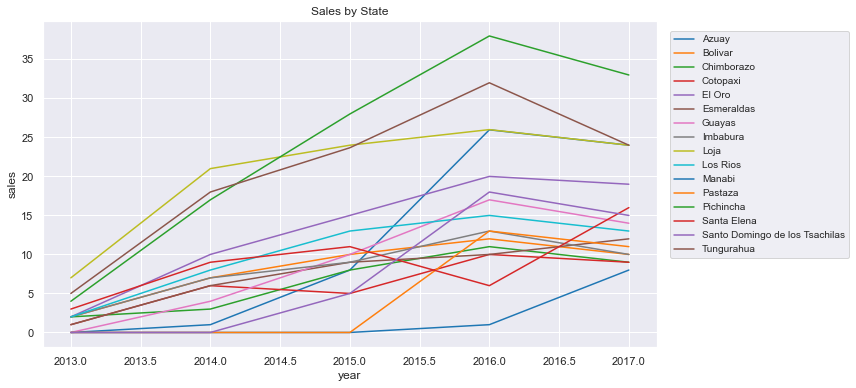

In [351]:
gr_state= all_data
gr_state.date=pd.to_datetime(gr_state.date)
gr_state["year"] = gr_state.date.dt.year
gr_state= gr_state.groupby(["state","year"]).sales.median().reset_index()
plt.title("Sales by State")
sns.lineplot(data=gr_state, x = "year", y = "sales", hue = "state", markers=True, palette = "tab10")
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=1, prop={'size': 10}, fancybox=True )
plt.show()

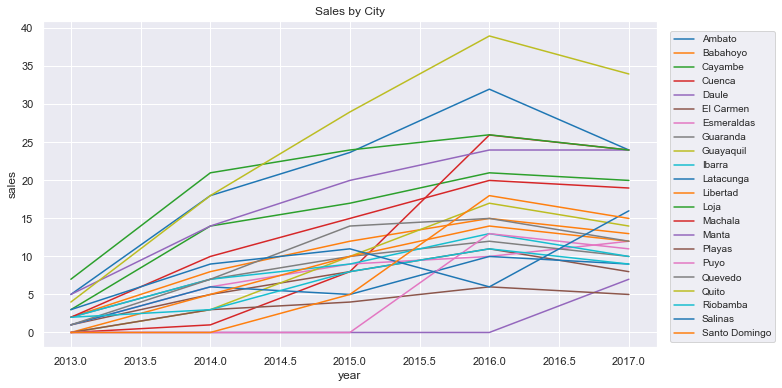

In [350]:
gr_city= all_data
gr_city.date=pd.to_datetime(gr_city.date)
gr_city["year"] = gr_city.date.dt.year
gr_city= gr_city.groupby(["city","year"]).sales.median().reset_index()
sns.lineplot(data=gr_city, x = "year", y = "sales", hue = "city", markers=True, palette = "tab10")
plt.title("Sales by City")
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=1, prop={'size': 10}, fancybox=True )
plt.show()

## 3) holidays_events.csv:

In [130]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### a. Transferred days:

Some national holidays has been transferred. In order to avoid duplicates, let's keep only the transferred instead of both (holiday and transferred):

In [131]:
# Delete transferred days from de holidays dataset and delete "transferred" column
holidays = holidays[(holidays.transferred == False)].drop("transferred", axis = 1).reset_index(drop = True)

### b. Work day:

Additional and Bridge days are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. Thus we'll delete this type of events from de Holidays dataset and store in a different file.

In [132]:
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]

### c. National, regional and local events:

Split holiday.csv in differents datasets for the porpose of merge theese with all_data.

Every Holiday with type= "Event" are National.

In [133]:
events = holidays[holidays.type == "Event"].drop(["type","locale", "locale_name"], axis = 1).rename({"description":"event"}, axis = 1)

In [134]:
holidays = holidays[holidays.type != "Event"].drop(["type"], axis= 1)

Local: refers to events that concern only a particular city

In [135]:
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"},
                                                    axis = 1).drop("locale", axis = 1).drop_duplicates()

In [136]:
local["holiday_local"] =np.where(local.holiday_local.str.contains("Fundacion de Guayaquil"), "Fundacion de Guayaquil", local.holiday_local)
local["holiday_local"] =np.where(local.holiday_local.str.contains("Fundacion de Quito"), "Fundacion de Quito", local.holiday_local)
#local.holiday_local.unique()

Regional: refers to the events which have a statal scope

In [137]:
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"},
                                                          axis = 1).drop("locale", axis = 1).drop_duplicates()

National: events which concern the hole country

In [138]:
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, 
                                                          axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()

In [139]:
national["holiday_national"] =np.where(national.holiday_national.str.contains("Navidad"), "Navidad", national.holiday_national)
national["holiday_national"] =np.where(national.holiday_national.str.contains("Primer dia"), "Primer dia del ano", national.holiday_national)

#### Merge national, regional, local, events and work_day with all_data:

In [140]:
national.date=pd.to_datetime(national.date)
regional.date=pd.to_datetime(regional.date)
local.date=pd.to_datetime(local.date)
work_day.date=pd.to_datetime(work_day.date)

In [141]:
# National
all_data= pd.merge(all_data, national, how = "left")

# Regional
all_data= pd.merge(all_data, regional, how = "left", on = ["date", "state"])

# Local
all_data= pd.merge(all_data, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
all_data= pd.merge(all_data,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

For **events** dataset, first we'll recategorize the categorical variable

In [142]:
# Futbol events simplifying the description
events["event"] =np.where(events.event.str.contains("futbol"), "Futbol", events.event)

In [143]:
events.head()

,date,event
54,2013-05-12,Dia de la Madre
101,2014-05-11,Dia de la Madre
104,2014-06-12,Futbol
105,2014-06-15,Futbol
106,2014-06-20,Futbol


In [144]:
# Terremoto events simplifying the description
events["event"] =np.where(events.event.str.contains("Terremoto"), "Terremoto", events.event)

In [145]:
events.event.unique()

array(['Dia de la Madre', 'Futbol', 'Black Friday', 'Cyber Monday',
       'Terremoto'], dtype=object)

In [146]:
events.date=pd.to_datetime(events.date)

In [147]:
all_data= pd.merge(all_data, events, how = "left")

In [148]:
# fillna() List
to_fillna=["sales", "holiday_national", "holiday_regional","holiday_local","IsWorkDay","event"]

In [149]:
all_data[to_fillna]=all_data[to_fillna].fillna(0)

## 4) Transactions.csv

Transactions means how many people came to the store or how many invoices created in a day. **sales**, our target value, gives the total sales for a product family at a particular store at a given date and fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance). That's why, transactions will be one of the relevant features in the model and we supose that this features are highly correlated with **sales**. In the following sections, we will generate new features in the main dataset by using transactions.

#### Data Exploratory:

Let's see the correlation between **date** and **transactions** by **store_nbr**. For that, we create a temporary feature which combines theese features. 

In [150]:
trans_corr = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")

print("Correlation between Total Sales and Transactions: {:,.4f}".format(trans_corr.corr().sales.loc["transactions"]))

Correlation between Total Sales and Transactions: 0.8374


That's a high correlation, let's visualize it 

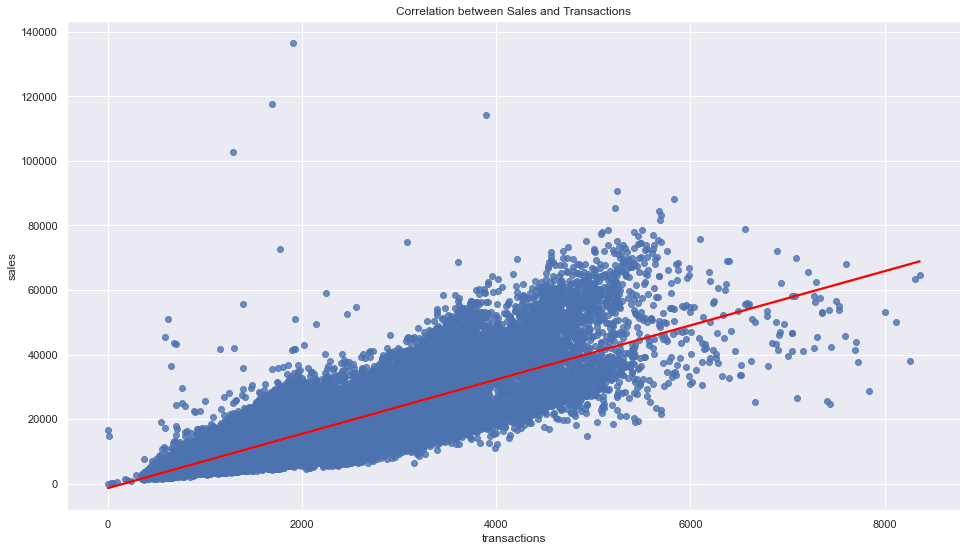

In [278]:
plt.title("Correlation between Sales and Transactions")
sns.regplot(x = trans_corr["transactions"], y = trans_corr["sales"], line_kws={"color": "red"}, ci=0)
plt.show()

Now we gonna see the **transactions** distribution by date, for each store.

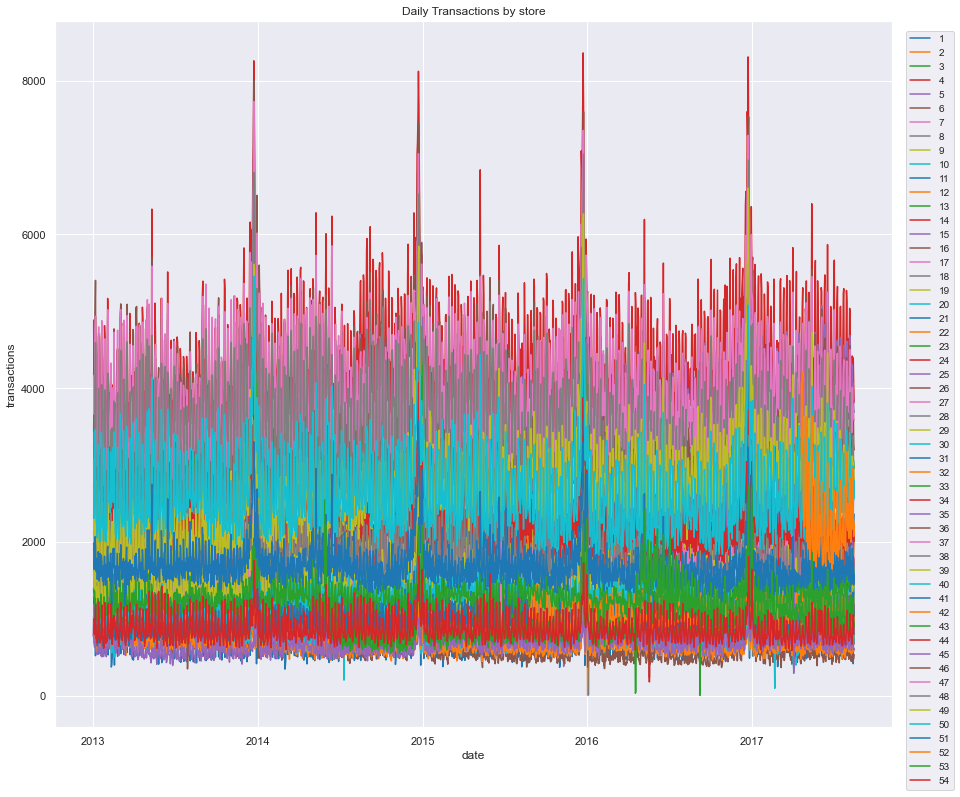

In [323]:
trans_date=transactions.sort_values(["store_nbr", "date"])
trans_date["date"]= pd.to_datetime(trans_date["date"])
plt.title("Daily Transactions by store")
sns.set(rc={'figure.figsize':(15,13)})
sns.lineplot(data=trans_date, x='date', y='transactions', hue="store_nbr", palette = sns.color_palette("tab10", 54))
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=1, prop={'size': 10}, fancybox=True )
plt.show()

We can clearly see an annual pattern in the **transactions** distribution, which have its peek at the end of every year.

It could be seen clearly in boxplot.

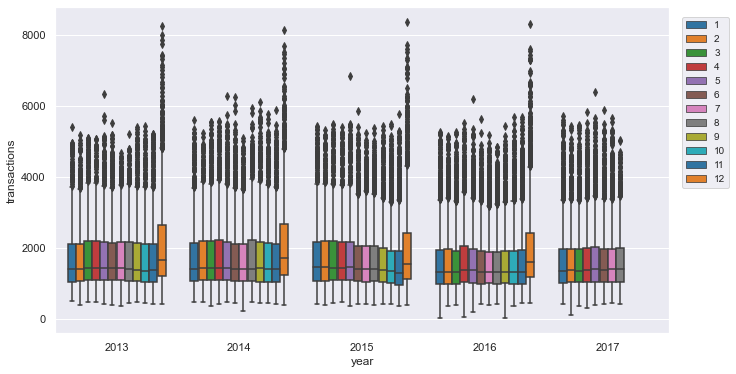

In [328]:
trans_month = transactions.copy()
trans_month["date"] = pd.to_datetime(trans_month.date) # For an easy access to year and month we applied .to_datetime
trans_month["year"] = trans_month.date.dt.year
trans_month["month"] = trans_month.date.dt.month
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(data=trans_month, x="year", y="transactions" , hue = "month", palette = sns.color_palette("tab10", 12))
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=1, prop={'size': 10}, fancybox=True )
plt.show()

We can conclude that there is a very important increase of the transaccions in December and this happened every year, so we couldn't treat it like an **outlier**

Let's explore what happened around the days of the week, creating a **Seasonal Plot**

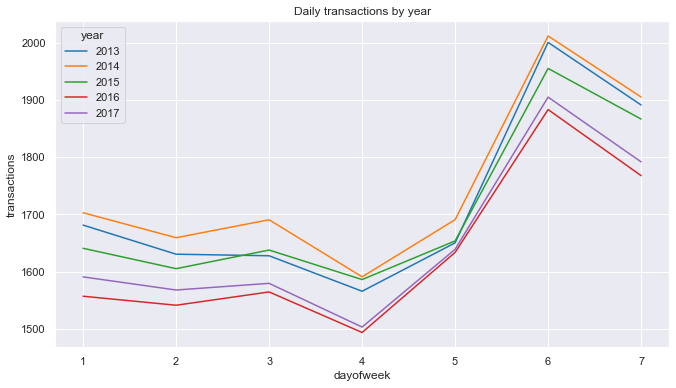

In [340]:
trans_day= trans_month.copy()
trans_day["year"] = trans_day.date.dt.year
trans_day["dayofweek"] = trans_day.date.dt.dayofweek+1
trans_day= trans_day.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
sns.lineplot(data=trans_day, x="dayofweek", y="transactions", hue = "year", palette="tab10")
plt.title("Daily transactions by year")
plt.show()

There is another clearly pattern, this one shows how increase the transactions near to the weekend and has its peak on saturdays.

### Forecasting transactions:

Since **transactions** are highly correlated with sales, we will attempt to forecast transactions 16 days out in order to include them in our model.

In [155]:
trans= transactions.copy()
trans["date"]= pd.to_datetime(trans["date"])
trans=trans.set_index(['store_nbr', 'date'])

Exploring the seasonality of transactions using **periodogram**.

In [156]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



/var/folders/26/pfkm7ks13rq_69fqmw98gfcw0000gn/T/ipykernel_4177/3491062708.py:2: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version



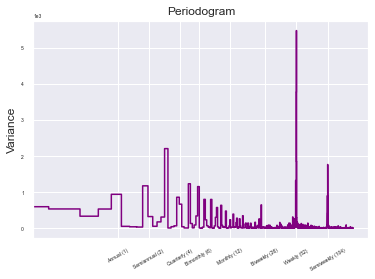

In [157]:
avr_trans=trans.groupby("date").mean().squeeze()
plot_periodogram(avr_trans)
plt.show()

The periodogram agrees with the analysis above: a strong weekly season, an intermediate semiannual season and a weaker annual season. The weekly season we'll model with indicators and the annual/semianual season with Fourier features.

In [158]:
trans=trans.unstack("store_nbr").fillna(method="bfill")
trans.index = pd.to_datetime(trans.index, unit='s')

### Choosing Fourier features with the Periodogram:
The weekly season we'll model with indicators and the annual season with Fourier features

In [159]:
fourier = CalendarFourier(freq='W', order=10)
dp = DeterministicProcess(
    index=trans.index,
    period=365,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X_trans = dp.in_sample()

model_trans = LinearRegression(fit_intercept=False)
model_trans.fit(X_trans, trans)
y_pred = pd.DataFrame(model_trans.predict(X_trans), index=X_trans.index, columns=trans.columns)

In [160]:
indx=pd.DataFrame(oil_data)
indx["date"]=pd.to_datetime(oil_data.date)
indx= indx.set_index("date")
indx= indx.loc['2017-08-16':]
inx=indx.index.unique() #Encontrar otro index de referencia porque X_test no va existir
X_trans_test= dp.out_of_sample(steps=16, forecast_index=inx)

In [161]:
y_trans = pd.DataFrame(model_trans.predict(X_trans_test), index=X_trans_test.index, columns=trans.columns)

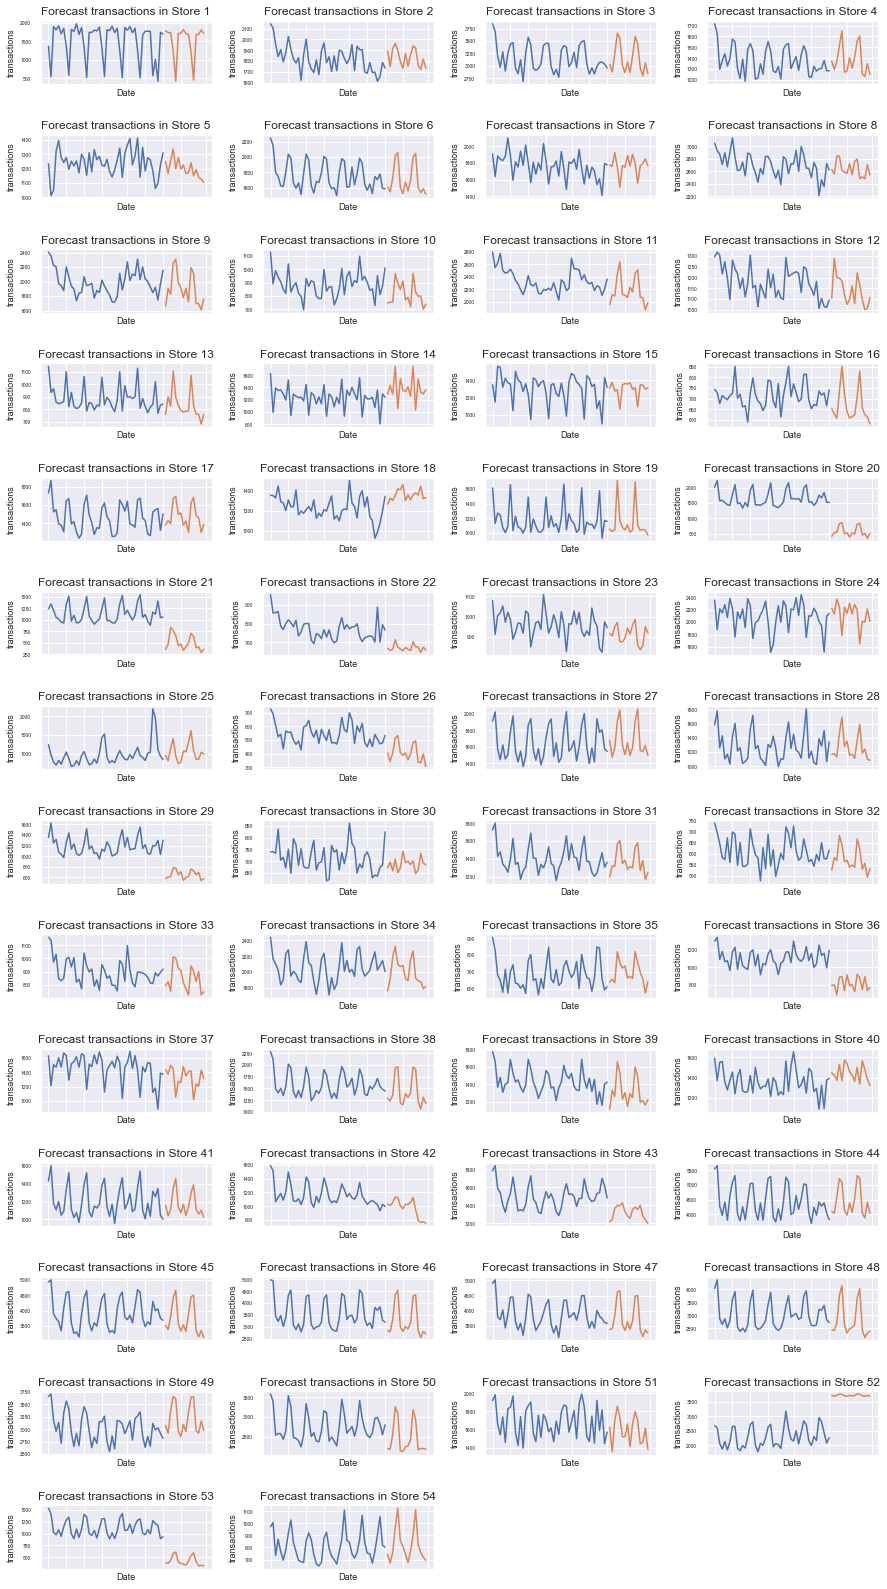

In [370]:
parameters = {'xtick.labelsize': 5, 'ytick.labelsize': 5}
plt.rcParams.update(parameters)

n=0
plt.figure(figsize=(15, 20))

for i in trans.transactions.columns:
    n=n+1
    plt.subplot(14,4,n)
    plt.title("Forecast transactions in Store %s"%(i))
    sns.lineplot(data=trans.transactions[i].loc["2017-07":])
    sns.lineplot(data=y_trans.transactions[i], palette=['g'])
    plt.tick_params(labelbottom=False, bottom=False)
    plt.ylabel("transactions", fontsize=9) 
    plt.xlabel("Date", fontsize=9) 
    
       
plt.subplots_adjust(top = 1.2, wspace=0.3, hspace=0.8)
plt.show()

In [163]:
trans_sum=trans.transactions.unstack().reset_index().set_index("date")
trans_sum.rename(columns={0:"transactions"}, inplace=True)
trans_sum= trans_sum.groupby("date")[["transactions"]].sum()

In [164]:
y_trans_sum=y_trans.transactions.unstack().reset_index().set_index("date")
y_trans_sum.rename(columns={0:"transactions"}, inplace=True)
y_trans_sum= y_trans_sum.groupby("date")[["transactions"]].sum()
y_trans_sum.rename(columns={"transactions":"forecasting transactions"}, inplace=True)

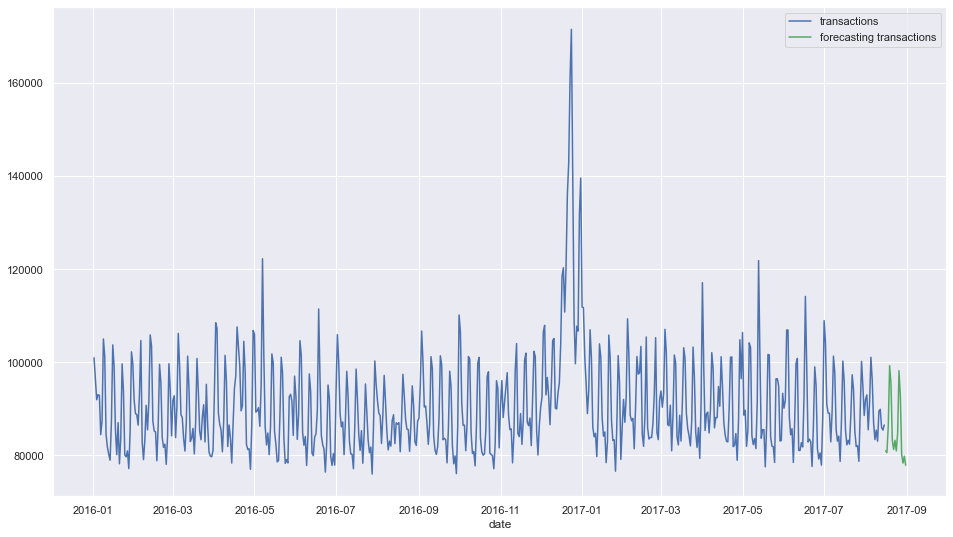

In [194]:
sns.lineplot(data=trans_sum.loc["2016":])
sns.lineplot(data=y_trans_sum, palette=['g'])
plt.show()

Now **concat** the original data with our forecast

In [166]:
trans_fore= pd.concat([trans, y_trans], sort= False)

Then **merge** the transactions forecasted dataset with all_data 

In [168]:
to_merge=trans_fore.stack("store_nbr").reset_index()
test=pd.merge(all_data, to_merge, how="left", on=["date","store_nbr"]).fillna(method="bfill")

# Preprocessing:

Columns to use: "date","store_nbr","family","sales","onpromotion","dayofweek","dcoilwtico","holiday_national","holiday_regional","holiday_local","IsWorkDay","event", "transactions".

In [169]:
cols_p=["date","store_nbr","family","sales","onpromotion","is_test","dcoilwtico", "city", "state", "cluster", "type_num","holiday_national","holiday_regional","holiday_local","IsWorkDay","event","transactions"]
data_clean=test[cols_p]

Encoding categorical data with **get_dummies** and more feature engineering. This isn't the best way to encode categorical variables outside the Kaggle's competitions. If we should be treat with unknown data, we'll use **OneHotEncoder** to make sure that both, in test and train data, there are the same categories for each variable.

In [170]:
data_X_2=data_clean.copy()

data_X_2["IsWorkDay"]=data_X_2["IsWorkDay"].apply(lambda x: 1 if x=="Work Day" else 0)

data_X_2["dayofweek"]=data_X_2["date"].dt.dayofweek

dummies_X_2= pd.get_dummies(data_X_2[["family","city","holiday_national","holiday_regional","holiday_local","event"]])

data_X_2=data_X_2.drop(axis=1, columns=["family","state","city","holiday_national","holiday_regional","holiday_local","event"])

X_2= pd.merge(data_X_2, dummies_X_2, left_index=True, right_index=True)

It is advisable not to incorporate variables in regression models that are highly correlated with each other. Let's check this out

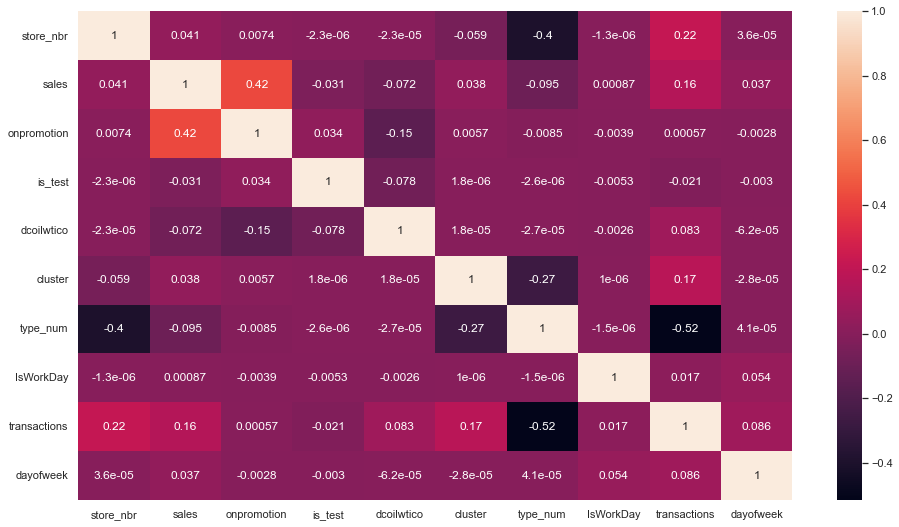

In [171]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.heatmap(data_X_2.corr(),annot=True)
plt.show()

**Split data** between train and test values

In [172]:
X=X_2[X_2.is_test==0].drop(["is_test"], axis=1)

X_id=X.index

X_test=X_2[X_2.is_test==1].drop(["is_test"], axis=1)

X_test_id=X_test.index

X=X.set_index("date")
X_test=X_test.set_index("date")

#X=X.loc["2016":]

y=X.sales

y_test=X_test.sales

X=X.drop(["sales"], axis=1)
X_test=X_test.drop(["sales"], axis=1)

### Model evaluating:

In [ ]:
#Con transactions
lr = LinearRegression()
cv = cross_val_score(lr,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

In [ ]:
#Con transactions
xgb = XGBRegressor(random_state=1)
cv = cross_val_score(xgb,X,y,cv=5)
print(cv)
print(cv.mean())

In [ ]:
rfr = RandomForestRegressor(random_state=1)
cv = cross_val_score(rfr,X,y,cv=5)
print(cv)
print(cv.mean())

## Model tunning:

Let's try to improve our models performance tunning its parameters. To do that, we use Scikit Learn methods: GridSearchCV

In [173]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)



## Training the best model:

In [ ]:
xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


# Predict

In [371]:
y_submit = pd.DataFrame(xgb_grid.predict(X_test), index=X_test.index, columns=["sales"])

In [379]:
#y_submit

### Replacing product family's sales in stores which this aren't available

In [373]:
zero_sales_d= pd.get_dummies(zero_sales[["family"]])
zero_sales_d= pd.merge(zero_sales[["store_nbr","sales"]], zero_sales_d, left_index=True, right_index=True)
zero_sales_d["sales_zero"]=1
zero_sales_d= zero_sales_d.drop("sales", axis=1)

In [374]:
X_z=X_test[["store_nbr", 'family_BABY CARE','family_BOOKS', 'family_LADIESWEAR','family_LAWN AND GARDEN',]]

In [375]:
y_submit_z= pd.concat([y_submit, X_z], axis=1)
y_submit_z= pd.merge(y_submit_z, zero_sales_d, how="left", on=["store_nbr", 'family_BABY CARE','family_BOOKS', 'family_LADIESWEAR','family_LAWN AND GARDEN',])

for i in y_submit_z.index:
    if y_submit_z["sales_zero"][i]==1:
        y_submit_z["sales"][i]=0

/var/folders/26/pfkm7ks13rq_69fqmw98gfcw0000gn/T/ipykernel_4177/2022310436.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [378]:
#y_submit_z.loc[y_submit_z.loc[:,"sales_zero"]==1]

In [377]:
y_submit= y_submit_z.drop(["store_nbr", 'family_BABY CARE','family_BOOKS', 'family_LADIESWEAR','family_LAWN AND GARDEN', "sales_zero"], axis=1)

## Preparing data for submission:

In [ ]:
y_submit_id= pd.read_csv("sample_submission.csv")
y_submit["id"]=y_submit_id["id"].values
y_submit["sales"]= y_submit["sales"].apply(lambda x: 0 if x<=0 else x)
y_submit= y_submit.reindex(columns=['id', 'sales'])

In [ ]:
y_submit.to_csv('submission_zero.csv', index=False)